In [1]:
# import functools
import os

# from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.2.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-10-21 18:55:51.079566: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-10-21 18:55:51.104070: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2400000000 Hz
2021-10-21 18:55:51.104627: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f707c000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-21 18:55:51.104656: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-21 18:55:51.106962: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-21 18:55:51.220244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 18:55:51.220765:

In [2]:
# # @title Define image loading and visualization functions  { display-mode: "form" }

# def crop_center(image):
#   """Returns a cropped square image."""
#   shape = image.shape
#   new_shape = min(shape[1], shape[2])
#   offset_y = max(shape[1] - shape[2], 0) // 2
#   offset_x = max(shape[2] - shape[1], 0) // 2
#   image = tf.image.crop_to_bounding_box(
#       image, offset_y, offset_x, new_shape, new_shape)
#   return image

# @functools.lru_cache(maxsize=None)
# def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
#   """Loads and preprocesses images."""
#   # Cache image file locally.
#   image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
#   # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
#   img = tf.io.decode_image(
#       tf.io.read_file(image_path),
#       channels=3, dtype=tf.float32)[tf.newaxis, ...]
#   img = crop_center(img)
#   img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
#   return img

# def show_n(images, titles=('',)):
#   n = len(images)
#   image_sizes = [image.shape[1] for image in images]
#   w = (image_sizes[0] * 6) // 320
#   plt.figure(figsize=(w  * n, w))
#   gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
#   for i in range(n):
#     plt.subplot(gs[i])
#     plt.imshow(images[i][0], aspect='equal')
#     plt.axis('off')
#     plt.title(titles[i] if len(titles) > i else '')
#   plt.show()

In [11]:
##### Utility functions related to showing and saving images

def show_img(images, titles=('',), figsize=(20, 8)):
  plt.figure(figsize=figsize)
  imgs = len(images)
  for i, img in enumerate(images):
    plt.subplot(1, imgs, i + 1)
    if type(img) == tf.python.framework.ops.EagerTensor:
      # The output image is by default an EagerTensor instance, hence we will need to squeeze the image dimensions for display
      images[i] = np.squeeze(images[i])
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
  plt.show()

def save_image(img, filename, savedir):
    plt.imsave(os.path.join(savedir, filename), img)

In [4]:
##### Utility functions related to loading the magenta model and stylizing image using magenta model

def load_magenta_model():
    cwd = os.getcwd()

    # Load image stylization module.
    hub_handle = os.path.join(cwd, 'models', 'magenta')
    hub_module = hub.load(hub_handle)
    return hub_module

def style_img_magenta(content_image, style_image, hub_module):
    # Convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]. Example using numpy:
    ctm = content_image.copy()
    stm = style_image.copy()
    ctm = ctm.astype(np.float32)[np.newaxis, ...] / 255.
    stm = stm.astype(np.float32)[np.newaxis, ...] / 255.

    # Optionally resize the images. It is recommended that the style image is about
    # 256 pixels (this size was used when training the style transfer network).
    # The content image can be any size.
    stm = tf.image.resize(stm, (256, 256))

    # Stylize image
    outputs = hub_module(tf.constant(ctm), tf.constant(stm))
    stylized_image = outputs[0]
    return stylized_image
hub_module = load_magenta_model()

2021-10-21 18:55:52.109493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 18:55:52.109768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2021-10-21 18:55:52.109808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-21 18:55:52.109821: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-21 18:55:52.109832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-10-21 18:55:52.109842: I tensorflow/stream_executor/pl

The content images available by default are: ['klcc.jpg', 'msia1.jpg', 'msia2.jpg', 'sanfran1.jpg', 'sanfran2.jpg', 'sanfran3.jpg']

The style images available by default are: ['kandinsky.jpg', 'seated-nude.jpg', 'shipwreck.jpg', 'starry-night.jpg', 'the_scream.jpg', 'woman-with-hat-matisse.jpg']



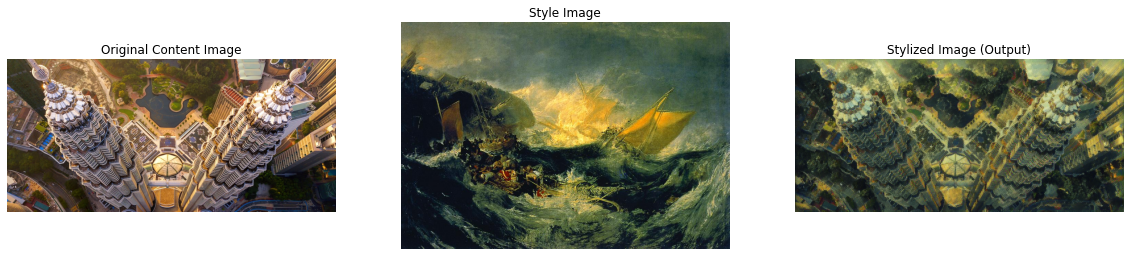

In [12]:
# Main program here
cwd = os.getcwd()
img_dir = os.path.join(cwd, 'images')
output_dir = os.path.join(cwd, 'output')

if not os.path.isdir(output_dir):
    os.mkdir(os.path.join(cwd, output_dir))

# Content image to be chosen
content_image_path = './klcc.jpg'
content_images = os.listdir(os.path.join(img_dir, 'content'))
content_images = sorted(content_images)
print(f'The content images available by default are: {content_images}\n')
content_img = content_images[0]
content_image_path = os.path.join(img_dir, 'content', content_img)
content_image = plt.imread(content_image_path)

# Choosing style image
style_images = os.listdir(os.path.join(img_dir, 'styles'))
style_images = sorted(style_images)
print(f'The style images available by default are: {style_images}\n')
style_img = style_images[2]

style_image_path = os.path.join(img_dir, 'styles', style_img)
style_image = plt.imread(style_image_path)


stylized_image = style_img_magenta(content_image=content_image, style_image=style_image, hub_module=hub_module)
stylized_image = np.squeeze(stylized_image)  # Prepare EagerTensor image for display

save_image(stylized_image, 'styled_output.jpg', output_dir)  # Save stylized image
show_img([content_image, style_image, stylized_image], titles=['Original Content Image', 'Style Image', 'Stylized Image (Output)'])